# **Gaussian Process Experiment (Different Seed Scenario)**

This notebook computes the Adapted Wasserstein Distance (AWD) between two Gaussian processes over a 4-dimensional space (`T = 4`) using **different seeds** for path generation. 

The objective is to study the impact of using different seeds on the estimation of the AWD.


## Imports and Setup

In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from optimal_code.utils import *
from optimal_code.optimal_solver import *
from adapted_empirical_measure.AEM_grid import *

## Experiment Parameters

In [2]:
sample_sizes = [1000, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]
fixed_grid = 0.1
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [1, 2, 0, 0],
              [1, 2, 3, 0],
              [1, 2, 3, 4]])
M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])


## Running Experiments

In [3]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        seed1 = np.random.randint(10000)  
        seed2 = np.random.randint(10000)
        while seed2 == seed1:  # Ensure seeds are different
            seed2 = np.random.randint(10000)

        # Generate sample paths
        X, A = Lmatrix2paths(L, n_sample, seed=seed1, verbose=False)
        Y, B = Lmatrix2paths(M, n_sample, seed=seed2, verbose=False)

        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared(A, B)
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        
        # Quantize paths using the mapping
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        
        # Sort the quantized paths (transposing to match the expected shape)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional distributions
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance and record computation time
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 1000


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 188.27it/s]

 79%|█████████████████████████████████▎        | 19/24 [00:00<00:00, 180.99it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 194.19it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 176.50it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 186.45it/s]

  0%|                                                    | 0/23 [00:00<?, ?it/s]

 87%|████████████████████████████████████▌     | 20/23 [00:00<00:00, 195.42it/s]


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 74.34it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]





100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 400.76it/s]


Sample size 1000, Run 1: AW_2^2 = 31.3873, Time = 3.6964 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.87it/s]

 88%|████████████████████████████████████▊     | 21/24 [00:00<00:00, 201.37it/s]

 83%|███████████████████████████████████       | 20/24 [00:00<00:00, 192.71it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 204.29it/s]


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 176.10it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.55it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 74.75it/s]

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 114.25it/s]

 32%|█████████████▉                              | 6/19 [00:00<00:00, 23.59it/s]

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 94.98it/s]

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 67.23it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 73.28it/s]


100%|█████████

Sample size 1000, Run 2: AW_2^2 = 31.3752, Time = 3.8465 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 159.41it/s]


  0%|                                                    | 0/24 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.43it/s]

 83%|███████████████████████████████████       | 20/24 [00:00<00:00, 198.15it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 179.06it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 146.57it/s]


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 187.04it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 171.52it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 173.66it/s]


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 125.52it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 57.54it/s]

  0%|                                                    | 0/19 [00:00<?, ?it/s]

100%|██████

Sample size 1000, Run 3: AW_2^2 = 28.8442, Time = 3.7391 s


 46%|███████████████████▎                      | 11/24 [00:00<00:00, 104.94it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 149.45it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 201.55it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 208.13it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 202.24it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 186.52it/s]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 72.39it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 59.50it/s]


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 49.65it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 44.83it/s]



  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|██████

Sample size 1000, Run 4: AW_2^2 = 26.0592, Time = 3.5574 s


  0%|                                                    | 0/24 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 127.55it/s]




100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 179.90it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 76.00it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 114.75it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 106.34it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.19it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 79.88it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 482.27it/s]


Sample size 1000, Run 5: AW_2^2 = 28.1137, Time = 3.7410 s


 83%|███████████████████████████████████       | 20/24 [00:00<00:00, 191.65it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 168.86it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 193.81it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 184.32it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.00it/s]

  0%|                                                    | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 60.67it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.99it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 70.12it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 71.10it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 764.69it/s]

100%|█████████

Sample size 1000, Run 6: AW_2^2 = 32.0760, Time = 3.5114 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 188.30it/s]


  0%|                                                    | 0/23 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 205.82it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 198.83it/s]


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 211.26it/s]


 63%|███████████████████████████▏               | 12/19 [00:00<00:00, 36.34it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 79.61it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 66.82it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 74.70it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.24it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1244.23it/s]

100%|███████

Sample size 1000, Run 7: AW_2^2 = 30.6678, Time = 3.5871 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 195.56it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 160.75it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 176.42it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 200.27it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 205.83it/s]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 62.03it/s]

 63%|███████████████████████████▏               | 12/19 [00:00<00:00, 45.95it/s]

 79%|█████████████████████████████████▉         | 15/19 [00:00<00:00, 62.49it/s]


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 81.86it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 79.42it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 56.01it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.24it/s]

100%|█████████

Sample size 1000, Run 8: AW_2^2 = 27.4860, Time = 3.7686 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 208.66it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.44it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 173.22it/s]

  0%|                                                    | 0/24 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 158.93it/s]




100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 170.03it/s]




100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 196.95it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 200.46it/s]


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 200.82it/s]

  0%|                                                    | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 73.21it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 51.99it/s]

100%|████

Sample size 1000, Run 9: AW_2^2 = 28.6053, Time = 3.7505 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 177.73it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 156.76it/s]

  0%|                                                    | 0/23 [00:00<?, ?it/s]



100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.14it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 194.16it/s]



 60%|█████████████████████████▏                | 12/20 [00:00<00:00, 115.62it/s]

 20%|████████▊                                   | 4/20 [00:00<00:00, 38.62it/s]

 60%|█████████████████████████▊                 | 12/20 [00:00<00:00, 55.16it/s]


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 100.29it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 62.51it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 30.73it/s]

  0%|      

Sample size 1000, Run 10: AW_2^2 = 30.6335, Time = 3.7513 s

Running experiments for sample size: 2000


 46%|███████████████████▋                       | 22/48 [00:00<00:00, 91.95it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 91.23it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 89.21it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 94.29it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 99.46it/s]

 36%|███████████████▋                           | 12/33 [00:00<00:00, 26.77it/s]

 91%|███████████████████████████████████████▏   | 31/34 [00:01<00:00, 14.73it/s]

 97%|█████████████████████████████████████████▋ | 33/34 [00:01<00:00, 26.12it/s]

100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 46.19it/s]

100%|███████████████████████████████████████████| 33/33 [00:01<00:00, 31.88it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 591.33it/s]


Sample size 2000, Run 1: AW_2^2 = 29.6731, Time = 7.5646 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 92.20it/s]


  0%|                                                    | 0/47 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 59.10it/s]

 71%|██████████████████████████████▎            | 24/34 [00:00<00:00, 32.44it/s]

 48%|████████████████████▊                      | 16/33 [00:00<00:00, 39.28it/s]

 76%|████████████████████████████████▌          | 25/33 [00:00<00:00, 46.24it/s]

100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 33.60it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 48.33it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 605.68it/s]


Sample size 2000, Run 2: AW_2^2 = 27.4930, Time = 7.1992 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 93.19it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 99.47it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 49.15it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 398.47it/s]


Sample size 2000, Run 3: AW_2^2 = 27.3770, Time = 7.6938 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 90.13it/s]

 21%|█████████▏                                 | 10/47 [00:00<00:00, 99.72it/s]

 57%|████████████████████████▋                  | 27/47 [00:00<00:00, 72.68it/s]



100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 20.81it/s]


100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 24.07it/s]


100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 31.51it/s]


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 33.14it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 63.01it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 406.82it/s]


Sample size 2000, Run 4: AW_2^2 = 28.7633, Time = 7.6251 s


 46%|███████████████████▋                       | 22/48 [00:00<00:00, 89.08it/s]


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 90.33it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 76.58it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 33.72it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.82it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.18it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1065.36it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 407.06it/s]


Sample size 2000, Run 5: AW_2^2 = 29.4147, Time = 7.6568 s


  0%|                                                    | 0/47 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 93.71it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 91.79it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 88.05it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 45.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 74.55it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 585.88it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 542.46it/s]


Sample size 2000, Run 6: AW_2^2 = 30.0806, Time = 7.0928 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 86.34it/s]

 21%|█████████▏                                 | 10/47 [00:00<00:00, 97.06it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 83.73it/s]

100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 22.95it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 61.49it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.98it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 409.52it/s]


Sample size 2000, Run 7: AW_2^2 = 29.5340, Time = 7.0670 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.60it/s]

 92%|███████████████████████████████████████▍   | 44/48 [00:00<00:00, 93.34it/s]

 62%|██████████████████████████▌                | 29/47 [00:00<00:00, 95.42it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 94.12it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 93.04it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 96.24it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 48.69it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 49.97it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 410.08it/s]


Sample size 2000, Run 8: AW_2^2 = 28.8309, Time = 7.8577 s


 98%|██████████████████████████████████████████ | 47/48 [00:00<00:00, 79.73it/s]

 38%|████████████████▍                          | 13/34 [00:00<00:00, 42.59it/s]

100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 21.99it/s]

100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.92it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 153.41it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 405.21it/s]


Sample size 2000, Run 9: AW_2^2 = 28.5332, Time = 7.1369 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 85.61it/s]

100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 33.50it/s]

100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 84.10it/s]

100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 31.97it/s]

 85%|████████████████████████████████████▋      | 29/34 [00:01<00:00, 16.74it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 65.65it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 577.17it/s]


Sample size 2000, Run 10: AW_2^2 = 27.7811, Time = 7.3633 s

Running experiments for sample size: 4000


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 43.59it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 42.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 342.56it/s]


Sample size 4000, Run 1: AW_2^2 = 31.1616, Time = 18.8093 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 301.64it/s]


Sample size 4000, Run 2: AW_2^2 = 31.2149, Time = 20.3880 s


 94%|████████████████████████████████████████▎  | 89/95 [00:01<00:00, 44.55it/s]

 88%|██████████████████████████████████████     | 84/95 [00:01<00:00, 44.62it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 42.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 529.72it/s]


Sample size 4000, Run 3: AW_2^2 = 28.9325, Time = 19.4784 s


 59%|█████████████████████████▏                 | 55/94 [00:01<00:00, 45.91it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 42.20it/s]

 77%|████████████████████████████████▉          | 72/94 [00:01<00:00, 47.20it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 41.89it/s]

 80%|██████████████████████████████████▎        | 75/94 [00:01<00:00, 47.99it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 44.65it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 65.17it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 383.08it/s]


Sample size 4000, Run 4: AW_2^2 = 28.9708, Time = 19.6987 s


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 42.50it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 44.96it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 43.50it/s]

 87%|█████████████████████████████████████▏     | 45/52 [00:02<00:00, 18.34it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.13it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 387.11it/s]


Sample size 4000, Run 5: AW_2^2 = 29.1557, Time = 18.5964 s


100%|███████████████████████████████████████████| 52/52 [00:05<00:00, 10.12it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 318.23it/s]


Sample size 4000, Run 6: AW_2^2 = 30.7920, Time = 19.9736 s


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 44.94it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 46.82it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 52.95it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 329.35it/s]


Sample size 4000, Run 7: AW_2^2 = 29.7906, Time = 21.3948 s


100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 43.99it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 382.03it/s]


Sample size 4000, Run 8: AW_2^2 = 30.2767, Time = 19.7087 s


 58%|████████████████████████▊                  | 30/52 [00:04<00:03,  5.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 341.50it/s]


Sample size 4000, Run 9: AW_2^2 = 29.5209, Time = 19.4520 s


  4%|█▋                                          | 2/52 [00:00<00:08,  5.59it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 380.95it/s]


Sample size 4000, Run 10: AW_2^2 = 29.1824, Time = 20.0166 s

Running experiments for sample size: 6000


 88%|████████████████████████████████████     | 125/142 [00:04<00:00, 27.97it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 362.17it/s]


Sample size 6000, Run 1: AW_2^2 = 29.8232, Time = 34.1971 s


100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 28.76it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 355.06it/s]


Sample size 6000, Run 2: AW_2^2 = 30.5582, Time = 35.0290 s


100%|█████████████████████████████████████████| 141/141 [00:05<00:00, 28.03it/s]

100%|███████████████████████████████████████████| 64/64 [00:10<00:00,  6.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.09it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 551.66it/s]


Sample size 6000, Run 3: AW_2^2 = 30.0156, Time = 34.7069 s


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 28.63it/s]

100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 29.50it/s]

100%|███████████████████████████████████████████| 64/64 [00:08<00:00,  7.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 411.57it/s]


Sample size 6000, Run 4: AW_2^2 = 28.9306, Time = 34.7152 s


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 268.37it/s]


Sample size 6000, Run 5: AW_2^2 = 30.1529, Time = 34.9220 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 370.23it/s]


Sample size 6000, Run 6: AW_2^2 = 30.1012, Time = 35.4686 s


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 29.76it/s]

 71%|█████████████████████████████            | 100/141 [00:03<00:01, 31.20it/s]

 95%|██████████████████████████████████████▉  | 134/141 [00:04<00:00, 32.88it/s]

100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 30.02it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 445.30it/s]


Sample size 6000, Run 7: AW_2^2 = 29.1694, Time = 34.0989 s


100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 30.95it/s]

100%|███████████████████████████████████████████| 64/64 [00:09<00:00,  6.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 448.68it/s]


Sample size 6000, Run 8: AW_2^2 = 30.5002, Time = 33.8886 s


 91%|█████████████████████████████████████▏   | 129/142 [00:04<00:00, 27.46it/s]

 68%|████████████████████████████▌             | 96/141 [00:03<00:01, 29.42it/s]

100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 28.22it/s]

100%|███████████████████████████████████████████| 64/64 [00:08<00:00,  7.36it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 498.31it/s]


Sample size 6000, Run 9: AW_2^2 = 30.9657, Time = 32.4722 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 373.46it/s]


Sample size 6000, Run 10: AW_2^2 = 28.9897, Time = 35.6445 s

Running experiments for sample size: 8000


 75%|██████████████████████████████▉          | 141/187 [00:06<00:01, 23.44it/s]

100%|███████████████████████████████████████████| 72/72 [00:12<00:00,  5.65it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 361.42it/s]


Sample size 8000, Run 1: AW_2^2 = 29.2474, Time = 50.0163 s


100%|███████████████████████████████████████████| 72/72 [00:10<00:00,  6.58it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 295.31it/s]


Sample size 8000, Run 2: AW_2^2 = 29.1453, Time = 53.3747 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 515.08it/s]


Sample size 8000, Run 3: AW_2^2 = 30.3848, Time = 53.6265 s


100%|█████████████████████████████████████████| 188/188 [00:08<00:00, 21.54it/s]

100%|█████████████████████████████████████████| 187/187 [00:08<00:00, 21.66it/s]

100%|█████████████████████████████████████████| 187/187 [00:08<00:00, 22.62it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 424.57it/s]


Sample size 8000, Run 4: AW_2^2 = 30.1635, Time = 51.9858 s


 93%|██████████████████████████████████████▏  | 175/188 [00:08<00:00, 17.14it/s]


 98%|████████████████████████████████████████ | 183/187 [00:08<00:00, 23.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 324.18it/s]


Sample size 8000, Run 5: AW_2^2 = 31.6813, Time = 54.4796 s


 77%|███████████████████████████████▌         | 144/187 [00:06<00:01, 22.24it/s]

100%|█████████████████████████████████████████| 187/187 [00:08<00:00, 22.88it/s]

100%|███████████████████████████████████████████| 72/72 [00:05<00:00, 14.40it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 354.64it/s]


Sample size 8000, Run 6: AW_2^2 = 31.1813, Time = 53.4413 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 278.93it/s]


Sample size 8000, Run 7: AW_2^2 = 30.7337, Time = 49.4601 s


100%|█████████████████████████████████████████| 187/187 [00:08<00:00, 21.98it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 549.71it/s]


Sample size 8000, Run 8: AW_2^2 = 30.6816, Time = 52.6937 s


100%|█████████████████████████████████████████| 187/187 [00:09<00:00, 20.43it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 370.72it/s]


Sample size 8000, Run 9: AW_2^2 = 29.2875, Time = 52.6658 s


100%|███████████████████████████████████████████| 74/74 [00:11<00:00,  6.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 302.27it/s]


Sample size 8000, Run 10: AW_2^2 = 30.7970, Time = 51.2483 s

Running experiments for sample size: 10000


 67%|███████████████████████████▍             | 156/233 [00:09<00:06, 11.65it/s]

 96%|███████████████████████████████████████▏ | 224/234 [00:13<00:00, 19.09it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 488.85it/s]


Sample size 10000, Run 1: AW_2^2 = 32.1053, Time = 71.6323 s


 86%|███████████████████████████████████▎     | 201/233 [00:12<00:01, 17.89it/s]

100%|█████████████████████████████████████████| 233/233 [00:13<00:00, 17.22it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 520.32it/s]


Sample size 10000, Run 2: AW_2^2 = 30.4616, Time = 72.8993 s


100%|█████████████████████████████████████████| 234/234 [00:13<00:00, 16.97it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 371.60it/s]


Sample size 10000, Run 3: AW_2^2 = 29.9914, Time = 75.4212 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 362.86it/s]


Sample size 10000, Run 4: AW_2^2 = 30.2966, Time = 71.5551 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 348.36it/s]


Sample size 10000, Run 5: AW_2^2 = 30.4851, Time = 72.7160 s


 80%|████████████████████████████████▋        | 186/233 [00:10<00:02, 20.45it/s]

100%|█████████████████████████████████████████| 234/234 [00:14<00:00, 16.58it/s]

100%|███████████████████████████████████████████| 80/80 [00:06<00:00, 11.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 483.55it/s]


Sample size 10000, Run 6: AW_2^2 = 30.4611, Time = 76.8116 s


100%|█████████████████████████████████████████| 234/234 [00:14<00:00, 16.53it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 395.02it/s]


Sample size 10000, Run 7: AW_2^2 = 30.1799, Time = 72.1837 s


100%|█████████████████████████████████████████| 234/234 [00:13<00:00, 17.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 360.00it/s]


Sample size 10000, Run 8: AW_2^2 = 31.9846, Time = 73.2755 s


100%|█████████████████████████████████████████| 233/233 [00:13<00:00, 17.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 532.95it/s]


Sample size 10000, Run 9: AW_2^2 = 31.4924, Time = 72.4732 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 350.75it/s]


Sample size 10000, Run 10: AW_2^2 = 30.0540, Time = 74.2063 s

Running experiments for sample size: 12000


 98%|████████████████████████████████████████▎| 274/279 [00:19<00:00, 15.80it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 360.83it/s]


Sample size 12000, Run 1: AW_2^2 = 31.0460, Time = 96.9765 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 288.76it/s]


Sample size 12000, Run 2: AW_2^2 = 30.3872, Time = 99.5300 s


100%|█████████████████████████████████████████| 280/280 [00:20<00:00, 13.63it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 265.65it/s]


Sample size 12000, Run 3: AW_2^2 = 30.8322, Time = 94.8939 s


100%|█████████████████████████████████████████| 280/280 [00:20<00:00, 13.84it/s]

100%|█████████████████████████████████████████| 280/280 [00:20<00:00, 13.82it/s]

100%|█████████████████████████████████████████| 279/279 [00:20<00:00, 13.91it/s]

100%|█████████████████████████████████████████| 279/279 [00:19<00:00, 14.18it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 288.23it/s]


Sample size 12000, Run 4: AW_2^2 = 30.9058, Time = 98.2674 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 463.36it/s]


Sample size 12000, Run 5: AW_2^2 = 30.9688, Time = 99.5733 s


100%|█████████████████████████████████████████| 279/279 [00:19<00:00, 14.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 269.85it/s]


Sample size 12000, Run 6: AW_2^2 = 30.3072, Time = 102.5045 s


 94%|██████████████████████████████████████▋  | 264/280 [00:19<00:01, 11.86it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 503.64it/s]


Sample size 12000, Run 7: AW_2^2 = 29.9485, Time = 92.9809 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 429.66it/s]


Sample size 12000, Run 8: AW_2^2 = 30.1329, Time = 96.6036 s


 90%|█████████████████████████████████████    | 252/279 [00:17<00:01, 15.51it/s]

100%|█████████████████████████████████████████| 279/279 [00:19<00:00, 14.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 343.23it/s]


Sample size 12000, Run 9: AW_2^2 = 30.9690, Time = 96.1965 s


100%|█████████████████████████████████████████| 280/280 [00:20<00:00, 13.72it/s]

100%|███████████████████████████████████████████| 85/85 [00:22<00:00,  3.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 287.38it/s]


Sample size 12000, Run 10: AW_2^2 = 30.5548, Time = 94.3661 s

Running experiments for sample size: 14000


 92%|█████████████████████████████████████▌   | 298/325 [00:26<00:01, 13.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 353.53it/s]


Sample size 14000, Run 1: AW_2^2 = 30.1281, Time = 121.9363 s


 92%|█████████████████████████████████████▋   | 299/325 [00:26<00:01, 15.10it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 498.61it/s]


Sample size 14000, Run 2: AW_2^2 = 29.7900, Time = 120.0184 s


 98%|████████████████████████████████████████▏| 318/324 [00:27<00:00, 14.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 445.26it/s]


Sample size 14000, Run 3: AW_2^2 = 30.5087, Time = 117.1400 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 326.66it/s]


Sample size 14000, Run 4: AW_2^2 = 30.9795, Time = 129.6432 s


 86%|███████████████████████████████████      | 278/325 [00:22<00:03, 14.01it/s]

 96%|███████████████████████████████████████▍ | 312/324 [00:24<00:00, 15.98it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 367.18it/s]


Sample size 14000, Run 5: AW_2^2 = 31.5612, Time = 123.5304 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 482.27it/s]


Sample size 14000, Run 6: AW_2^2 = 30.1600, Time = 120.1911 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 274.93it/s]


Sample size 14000, Run 7: AW_2^2 = 29.7232, Time = 123.6598 s


 93%|██████████████████████████████████████   | 302/325 [00:25<00:01, 13.36it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 474.84it/s]


Sample size 14000, Run 8: AW_2^2 = 30.9573, Time = 121.3973 s


100%|█████████████████████████████████████████| 325/325 [00:26<00:00, 12.09it/s]

100%|█████████████████████████████████████████| 325/325 [00:26<00:00, 12.44it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 497.84it/s]


Sample size 14000, Run 9: AW_2^2 = 30.8044, Time = 119.7565 s


100%|█████████████████████████████████████████| 325/325 [00:25<00:00, 12.59it/s]

100%|███████████████████████████████████████████| 89/89 [00:08<00:00, 10.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 409.36it/s]


Sample size 14000, Run 10: AW_2^2 = 31.1279, Time = 120.9803 s

Running experiments for sample size: 160000


  1%|▎                                        | 26/2941 [00:28<52:50,  1.09s/it]

  0%|                                        | 8/2941 [00:35<3:38:37,  4.47s/it]







































KeyboardInterrupt: 

## Aggregated Results and Plotting


Aggregated Results:
Sample Size: 1000
  Mean AW_2^2: 29.5248 ± 1.8816
  Mean Time: 3.6949 s ± 0.1015 s
  Mean Absolute Error: 1.7031 ± 0.9303
  Benchmark: 30.0000

Sample Size: 2000
  Mean AW_2^2: 28.7481 ± 0.9020
  Mean Time: 7.4257 s ± 0.2737 s
  Mean Absolute Error: 1.2680 ± 0.8792
  Benchmark: 30.0000

Sample Size: 4000
  Mean AW_2^2: 29.8998 ± 0.8534
  Mean Time: 19.7517 s ± 0.7494 s
  Mean Absolute Error: 0.7892 ± 0.3397
  Benchmark: 30.0000

Sample Size: 6000
  Mean AW_2^2: 29.9207 ± 0.6596
  Mean Time: 34.5143 s ± 0.8678 s
  Mean Absolute Error: 0.5381 ± 0.3896
  Benchmark: 30.0000

Sample Size: 8000
  Mean AW_2^2: 30.3303 ± 0.8215
  Mean Time: 52.2992 s ± 1.5408 s
  Mean Absolute Error: 0.7943 ± 0.3912
  Benchmark: 30.0000

Sample Size: 10000
  Mean AW_2^2: 30.7512 ± 0.7576
  Mean Time: 73.3174 s ± 1.6096 s
  Mean Absolute Error: 0.7529 ± 0.7559
  Benchmark: 30.0000

Sample Size: 12000
  Mean AW_2^2: 30.6052 ± 0.3734
  Mean Time: 97.1893 s ± 2.7000 s
  Mean Absolute Error: 0.

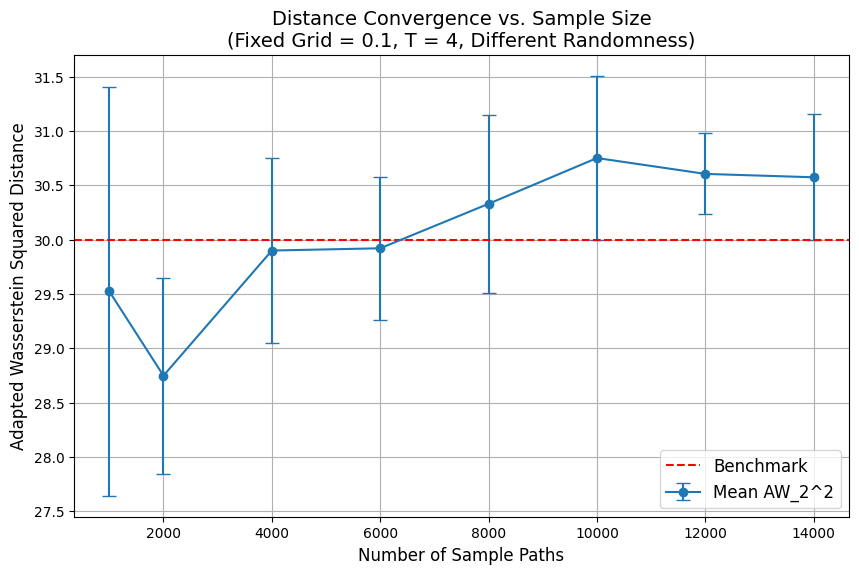

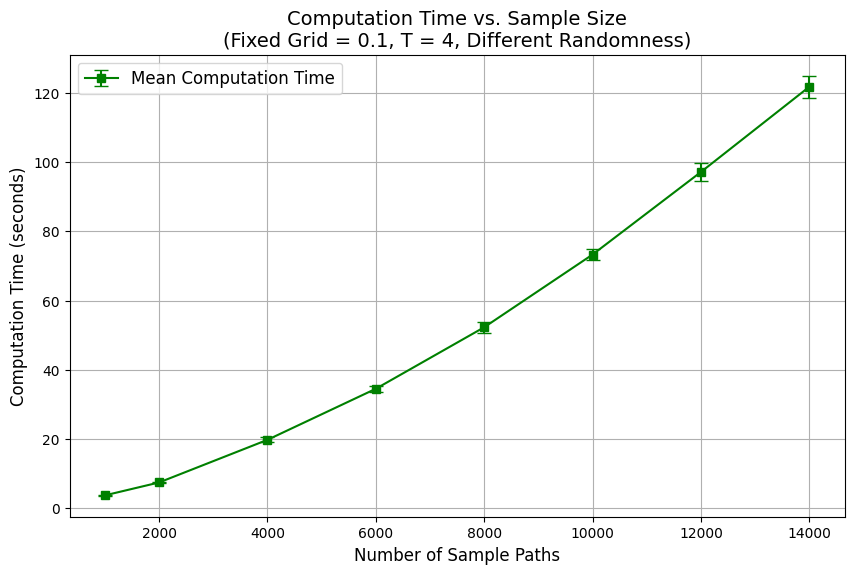

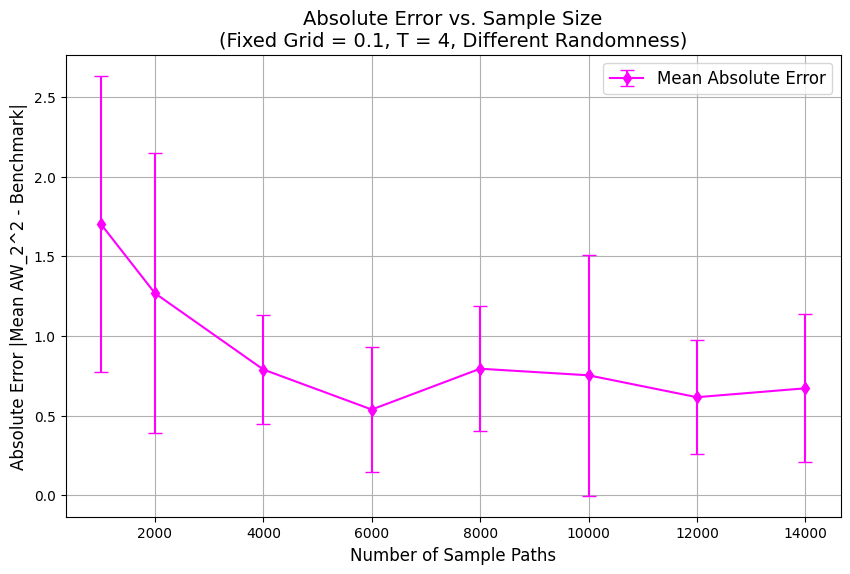

In [4]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Different Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Different Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Different Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()